In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
import random

from EDLA_no_negative_in_the_last_layer import EDLA_Multi
from criterion import evaluate_model
from datasets import load_dataset


def set_seed(seed: int = 0, deterministic: bool = True):
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    if deterministic:
        # 速度は少し落ちますが、再現性を優先
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # PyTorch の deterministic 制約（非対応opがあると例外/警告）
        torch.use_deterministic_algorithms(True, warn_only=True)


# =========================
# ここを好きな seed に
# =========================
SEED = 0
set_seed(SEED)


# -----------------------------------------------------
# Setup device
# -----------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -----------------------------------------------------
# Define the dataset type
# Options: "digits", "mnist", "fashion_mnist"
# -----------------------------------------------------
dataset_type = "digits"

# -----------------------------------------------------
# Set the hyperparameters
# -----------------------------------------------------
num_epochs         = 500
learning_rate      = 1.0
batch_size         = 128

input_size         = 64
hidden_size        = 2
num_layers         = 1
output_size        = 10
activation_fn      = "Sigmoid"
last_activation_fn = "Sigmoid"
loss_function      = "MSE"

# -----------------------------------------------------
# Load the dataset
# -----------------------------------------------------
train_loader, test_loader = load_dataset(dataset_type, batch_size)

train_losses     = np.zeros(num_epochs)
train_accuracies = np.zeros(num_epochs)
test_losses      = np.zeros(num_epochs)
test_accuracies  = np.zeros(num_epochs)

# -----------------------------------------------------
# Create an instance of the EDLA multi model
# -----------------------------------------------------
model = EDLA_Multi(
    input_size         = input_size,
    hidden_size        = hidden_size,
    learning_rate      = learning_rate,
    hidden_layers      = num_layers,
    output_size        = output_size,
    activation_fn      = activation_fn,
    last_activation_fn = last_activation_fn,
    loss_fc            = loss_function    
    ).to(device)

Using device: cpu


In [2]:
# -----------------------------------------------------
# Train the model
# -----------------------------------------------------
for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # Execute training in mini-batches
    for inputs, targets in train_loader:
        targets = torch.nn.functional.one_hot(targets, num_classes=output_size).float()
        model.update(inputs.to(device).flatten(1), targets.to(device))

    # Evaluate the model on the training and test datasets
    train_loss, train_accuracy = evaluate_model(model, train_loader, device, dataset = dataset_type)
    test_loss,  test_accuracy  = evaluate_model(model, test_loader, device, dataset = dataset_type)

    train_losses[epoch]     = train_loss
    train_accuracies[epoch] = train_accuracy
    test_losses[epoch]      = test_loss
    test_accuracies[epoch]  = test_accuracy

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    if (epoch + 1) % 20 == 0 or epoch == 0:  # Print every 20 epochs and the first epoch
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} | "
              f"Time: {epoch_duration:.2f} seconds")




Epoch 1/500 | Train Loss: 0.0949, Train Accuracy: 0.3382 | Test Loss: 0.0951, Test Accuracy: 0.2444 | Time: 2.71 seconds
Epoch 20/500 | Train Loss: 0.0222, Train Accuracy: 0.9339 | Test Loss: 0.0240, Test Accuracy: 0.9333 | Time: 0.03 seconds
Epoch 40/500 | Train Loss: 0.0129, Train Accuracy: 0.9506 | Test Loss: 0.0147, Test Accuracy: 0.9528 | Time: 0.02 seconds
Epoch 60/500 | Train Loss: 0.0107, Train Accuracy: 0.9603 | Test Loss: 0.0127, Test Accuracy: 0.9528 | Time: 0.02 seconds
Epoch 80/500 | Train Loss: 0.0095, Train Accuracy: 0.9638 | Test Loss: 0.0109, Test Accuracy: 0.9611 | Time: 0.02 seconds
Epoch 100/500 | Train Loss: 0.0083, Train Accuracy: 0.9708 | Test Loss: 0.0106, Test Accuracy: 0.9556 | Time: 0.02 seconds
Epoch 120/500 | Train Loss: 0.0078, Train Accuracy: 0.9736 | Test Loss: 0.0103, Test Accuracy: 0.9611 | Time: 0.02 seconds
Epoch 140/500 | Train Loss: 0.0079, Train Accuracy: 0.9743 | Test Loss: 0.0101, Test Accuracy: 0.9639 | Time: 0.02 seconds
Epoch 160/500 | Train 

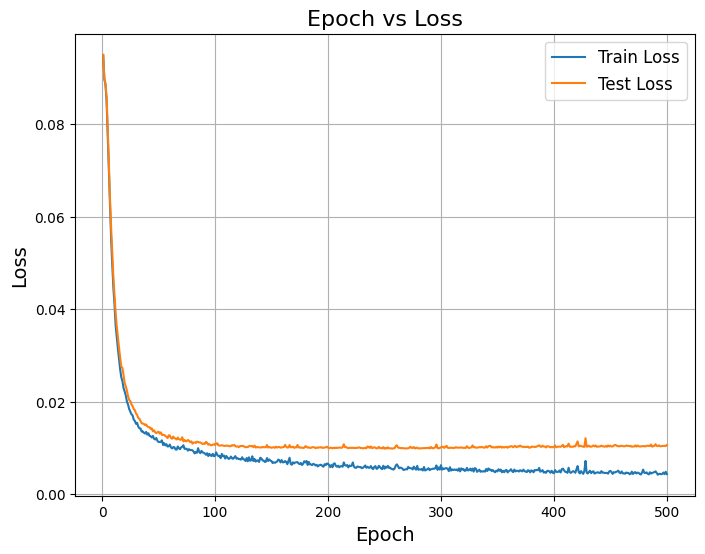

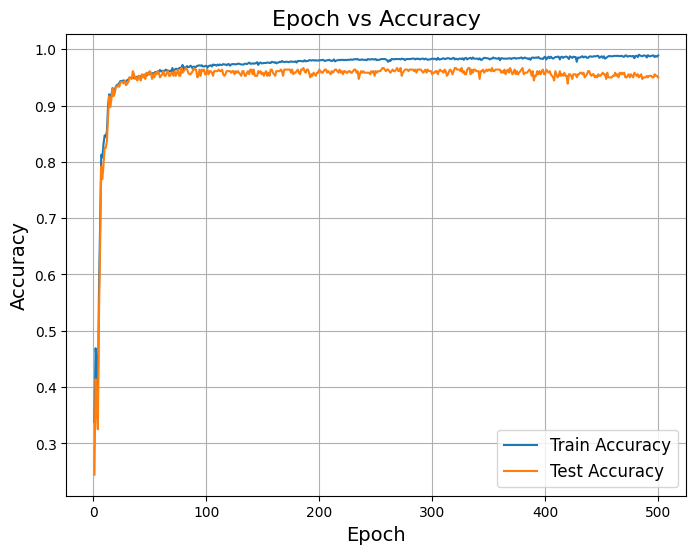

In [3]:
# -----------------------------------------------------
# Plot the results
# -----------------------------------------------------
import matplotlib.pyplot as plt

# Plot epoch vs loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Epoch vs Loss', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot epoch vs accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Epoch vs Accuracy', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Saved figure to ./selected_layers_fixed_grid.eps


/var/folders/0f/p1myltc16bq5dgqxpx4nq7j00000gp/T/ipykernel_35721/618540843.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1.0])


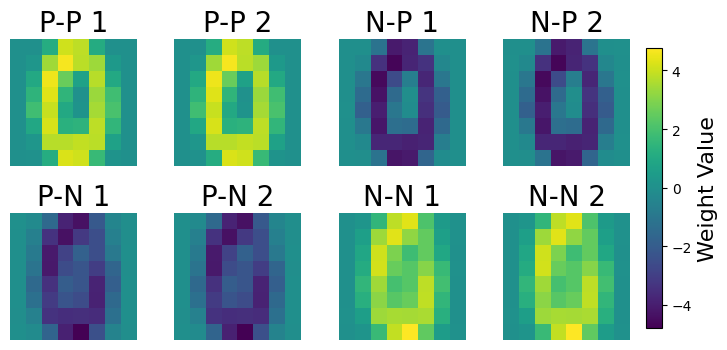

In [4]:
# -----------------------------------------------------
# Show the model weights
# -----------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import torch  # 必要に応じてインポート
from matplotlib.gridspec import GridSpec

def plot_model_weights_fixed_grid(
    model,
    layers_to_display,
    neuron_titles=None,
    neurons_per_layer=4,
    title_fontsize=18,
    cbar_labelpad=4,
    save_images=False,
    save_dir='.'
):
    if save_images and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # レイヤー重み収集
    layer_weights = {}
    for name, param in model.named_parameters():
        if name in layers_to_display and 'weight' in name:
            layer_weights[name] = param.data.cpu().numpy()
    if not layer_weights:
        print("指定された層が見つかりませんでした。")
        return
    
    num_layers = len(layer_weights)
    expected_neurons = neurons_per_layer
    
    # neuron_titles の検証・設定
    if neuron_titles is not None:
        if len(neuron_titles) != num_layers or any(len(t)!=expected_neurons for t in neuron_titles):
            print("Error: neuron_titles のサイズが正しくありません。")
            return
    else:
        neuron_titles = [[f'N{j}' for j in range(expected_neurons)] for _ in range(num_layers)]
    
    # カラースケール統一
    all_w = np.concatenate(list(layer_weights.values()), axis=0)
    vmin, vmax = all_w.min(), all_w.max()
    
    # Figure + GridSpec
    fig = plt.figure(figsize=(expected_neurons*2, num_layers*2))
    gs = GridSpec(
        nrows=num_layers,
        ncols=expected_neurons,
        width_ratios=[2]*expected_neurons,
        wspace=0.3,
        hspace=0.3
    )
    
    # ヒートマップ描画
    for i, (layer_name, W) in enumerate(layer_weights.items()):
        out_f, in_f = W.shape
        side = 8 if in_f==64 else int(np.ceil(np.sqrt(in_f)))
        
        for j in range(expected_neurons):
            ax = fig.add_subplot(gs[i, j])
            if j < out_f:
                w = W[j]
                if in_f == 64:
                    img = w.reshape(side, side)
                else:
                    padded = np.pad(w, (0, side*side - in_f), 'constant')
                    img = padded.reshape(side, side)
                im = ax.imshow(img, cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title(neuron_titles[i][j], fontsize=title_fontsize)
            ax.axis('off')
    
    # カラーバー
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Weight Value', fontsize=16, labelpad=cbar_labelpad)
    
    # tight_layout で余白を詰める
    plt.tight_layout(rect=[0, 0, 0.88, 1.0])
    
    # 保存時に bbox_inches='tight' を指定
    if save_images:
        outpath = os.path.join(save_dir, 'selected_layers_fixed_grid.eps')
        plt.savefig(
            outpath,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1
        )
        print(f"Saved figure to {outpath}")
    
    plt.show()



layers = [
    'edlas.0.layers.0.fc_p.weight',
    'edlas.0.layers.0.fc_n.weight'
]
titles = [
    ['P-P 1', 'P-P 2', 'N-P 1', 'N-P 2'],
    ['P-N 1', 'P-N 2', 'N-N 1', 'N-N 2']
]

plot_model_weights_fixed_grid(
    model,
    layers_to_display=layers,
    neuron_titles=titles,
    neurons_per_layer=4,
    title_fontsize=20,
    save_images=True,
    save_dir='.'
)


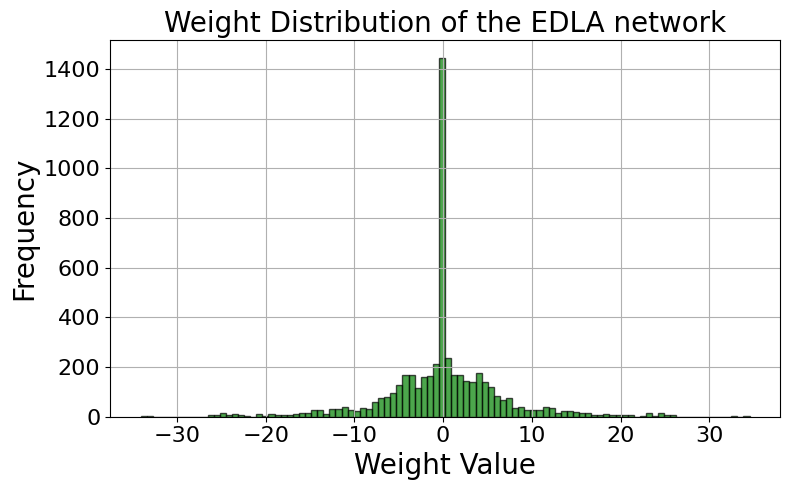

Saved weight distribution to ./weight_distribution.eps
Mean:  -0.0019094315 STD:  6.7858005


<Figure size 640x480 with 0 Axes>

In [5]:
# -----------------------------------------------------
# Show the weight distribution
# -----------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

def plot_weight_histograms(model, title_fontsize=28, label_fontsize=28, tick_fontsize=20, save_image=False, save_dir='.'):
    all_weights = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights = param.data.cpu().numpy().flatten()
            all_weights.extend(weights)
                            

    # 全ての重みを一つにまとめたヒストグラム
    plt.figure(figsize=(8, 5))  # 図のサイズを調整（必要に応じて変更）
    plt.hist(all_weights, bins=100, alpha=0.7, color='green', edgecolor='black')
    plt.title('Weight Distribution of the EDLA network', fontsize=title_fontsize)
    plt.xlabel('Weight Value', fontsize=label_fontsize)
    plt.ylabel('Frequency', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.grid(True)
    plt.tight_layout()  # レイアウトの調整
    plt.show()
    if save_image:
        outpath = os.path.join(save_dir, 'weight_distribution.eps')
        plt.savefig(outpath, dpi=300, bbox_inches='tight', pad_inches=0.1)
        print(f"Saved weight distribution to {outpath}")

    print("Mean: ", np.array(all_weights).mean(), "STD: ", np.array(all_weights).std())    

# ヒストグラムをプロット
plot_weight_histograms(model, title_fontsize=20, label_fontsize=20, tick_fontsize=16, save_image=True, save_dir='.')